#### 1. Импорты + insttall  Bertopic + загрузка  russian_stopwords


Корректная работа ноутбука предполагает установку папки модуля, являющейся пакетом, в каталог, содержащий этот ноутбук, а также наличие файла .env для хранения переменных окружения.
YC_API_KEY = '......'  для yndexgpt
FOLDER_ID  = '......'  id  фодера в yandexcloud

Yandex Foundation Models	Text generation	
0,20 ₽ 1k*unit	3 декабря 2024 г. (Стоимость генерации)

<pre><code>
main_topic_cloud/
|- .env
|- data/
|- module
     |- __init__.py
     |- DictDictToDataFrameParser
     |- InitBertopic
     |- llm_cloud.py
|- bertopic_add_LLM.ipynb
</code></pre>

In [2]:
# !pip install openpyxl

In [ ]:
import warnings
import nltk
import torch
import  numpy as np
import re
import pandas as pd
import os
import tiktoken
from pathlib import Path

from langchain_community.chat_models import ChatYandexGPT
from langchain_core.prompts import ChatPromptTemplate

from dotenv import load_dotenv,find_dotenv
from typing import Optional

from transformers import AutoTokenizer, pipeline
from pathlib import Path
from nltk.corpus import stopwords 

from  module.DictToDataFrameParser import DictToDataFrameParser
from  module.InitBertopic import InitBertopic
from  module.TopicLLMll import TopicLLMll
warnings.filterwarnings('ignore', category=UserWarning, module='transformers')
warnings.filterwarnings('ignore', category=FutureWarning, module='transformers')



In [ ]:
 InitBertopic, TopicLLMll

DictDictToDataFrameParser:<br>
def __init__(self, path: Path, columns: Optional[dict[str, str]] = None):<br>
path - путь  *json

атрибуты:
- path (Path): Путь к JSON-файлу, из которого будет загружен словарь.
- columns (dict): Словарь, где ключи соответствуют ключам из JSON-структуры, 
                    а значения — названиям столбцов в первичном DataFrame.
- result_dict (dict): Десериализованный словарь, полученный из JSON-файла.
- df (DataFrame): DataFrame, созданный на основе данных из result_dict и columns
- name: Название чата

InitBertopic:

 def __init__(self,
             nr_topics: Optional[int] = None,
             top_n_words: int = 10,   
             model: Optional[str] = None, 
             umap_dict: Optional[dict] = None, 
             hdbscan_dict: Optional[dict] = None,
             vectorizer_dict: Optional[dict] = None, 
             tf_idf_dict: Optional[dict] = None) -> None:

Инициализирует Bertopic c заданными парамтрами,
атрибут:
- topic_mode - инициализированная модель Bertopic
- bertopic_dict - словарь спарметрами инициализированной модели

методы работы  berttopic:
**name_model** = InitBertopic(...)

- **name_model**.topic_model.fit_transform(text: list[str]) - кластеризация
- **name_model**.topic_model.get_topic_info() - результат
- **name_model**.topic_model.get_topic([int]) - ключевые слова топика
- **name_model**.topic_model.get_topic_freq() -датафрейм с меткой кластера и частотой

In [8]:

# stop words для 'Vectorizers in BERTopic'
try:
    russian_stopwords = stopwords.words("russian") 
except:
    nltk.download("stopwords")
    russian_stopwords = stopwords.words("russian")

In [9]:
# Проверка наличия .env  в  каталоге  проекта и установка переменных окружения True - успех! 
# Перенесена в llm_cloud.py
# load_dotenv(find_dotenv())

In [10]:
pattern  = r'[^\w,.\!? ]'
def cleaned_string(string: str, pattern: str = pattern) -> str: 
    '''
    По умолчанию  удаляются все символы, не являющиеся буквами, цифрами, пробелами и знаками 
                   препинания.
    Замена гиперссылок на  подстроку "гиперссылка"
    '''
    # Вопрос к ревью - замена  гипрссылок на ключевое слово гипрессылка стоит ли???
    string = re.sub(r'https?://\S+', 'гиперсссылка', string)
    return re.sub(pattern, '', string).strip()

In [11]:


#Для подготовки текста принята гипотеза (вопрос к ревью — как проверить?): текстовые признаки в наблюдениях являются зависимыми.
#Признаки, составляющие цепочку ответов (например, родительское сообщение и ответы на него), принадлежат одному кластеру.
#Для кластеризации выбираются независимые признаки, а также те, которые в результате среза не имеют ссылки на родительский признак,
#включая ответные сообщения на родительские сообщения, которые были удалены.


def text_preparation( df: pd.DataFrame, len_text: str = 3) -> tuple[list[int],list[str]]:
    ''' Подготавливает текстовые данные для передачи в BERTopic:
        применяет к каждому тексту функцию `cleaned_string`,
        и возвращает два списка:
        - список индексов для кластеризации,
        - очищенные строки (тексты), которые можно передать в модель.
        len_text -минимальная длина текста
    '''
    # Вопрос  ревью -каое значение len_text выбрать? (длина в символах не в словах!!!)
    if not isinstance(df, pd.DataFrame):
       raise TypeError("Expected DataFrame, got another type.")
    if  'text'not in df.columns:
       raise KeyError("Column 'text' is missing in the DataFrame")
    # Если в JSON есть reply_to_message_id, столбец будет типа int. (явно был приведен в DictDictToDataFrameParser)   
    if  'reply_to_message_id' in  df.columns and df.df.reply_to_message_id.dtype =='int64':  
        # список  значений df.reply_to_message_id  для которых нет исходного сообщения
        set_replay = set(df.reply_to_message_id)  - set(df.df.message_id) - {-1}
        df_without_replay = df.query('reply_to_message_id == -1 or reply_to_message_id in @set_replay')
        
        text = list(df_without_replay[df_without_replay['text'].str.len() >= len_text]['text'].items())
    else:
        text = list(df[df['text'].str.len() >= len_text]['text'].items())
           
    
    return  map(list,zip(*text)) 
    

In [12]:
#  Подготовка  текста без   учета  зависимости цепочек ответов (Гипотеза -тексты независмые)

def text_preparation_with_replay( df: pd.DataFrame, len_text: str = 3) -> tuple[list[int],list[str]]:
    ''' Подготавливает текстовые данные для передачи в BERTopic:
        применяет к каждому тексту функцию `cleaned_string`,
        и возвращает два списка:
        - список индексов для кластеризации,
        - очищенные строки (тексты), которые можно передать в модель.
        len_text -минимальная длина текста
    '''
    # Вопрос  ревью -каое значение len_text выбрать? (длина в символах не в словах!!!)
    if not isinstance(df, pd.DataFrame):
       raise TypeError("Expected DataFrame, got another type.")
    if  'text'not in df.columns:
       raise KeyError("Column 'text' is missing in the DataFrame")
   
    text = list(df[df['text'].str.len() >= len_text]['text'].items())
           
    
    return  map(list,zip(*text)) 
    

### 2. Загрузка данных 

In [14]:
folder_ignore = '.ipynb_checkpoints'
path_list =[  i for i  in Path.cwd().rglob('*.json') if folder_ignore not in list(i.parent.parts) ]

# Список путей к файлам с json (парсим  рабочий каталог+ все  внего вложенные, кроме  '.ipynb_checkpoints')
[ (path_list, f'id_path:{i}')   for i, path_list      in enumerate(path_list)]

[(WindowsPath('C:/Users/dmitr/project_loc/masterskay/Masterskaya/data/example/result.json'),
  'id_path:0'),
 (WindowsPath('C:/Users/dmitr/project_loc/masterskay/Masterskaya/data/дата/result.json'),
  'id_path:1'),
 (WindowsPath('C:/Users/dmitr/project_loc/masterskay/Masterskaya/data/маркетинг/result.json'),
  'id_path:2'),
 (WindowsPath('C:/Users/dmitr/project_loc/masterskay/Masterskaya/data/менеджмент/result.json'),
  'id_path:3')]

**Число  в кортеже ( Path, int)  потребуется для выбора нужного файла .json**

In [16]:
INDEX =len(path_list)
while INDEX >= len(path_list) or INDEX <0:
    INDEX = int(input(f'Введи id_path (число от 0 до {len(path_list)-1}) и  Enter нажми'))
    if INDEX >= len(path_list):
        print( 'Введенное значение превышает допустимый диапазон')

Введи id_path (число от 0 до 3) и  Enter нажми 1


In [17]:
df_1 = DictToDataFrameParser(path_list[INDEX])
df_1.name

'💬 Data Practicum Chat'

In [18]:
df_1.df.head(5)

,date,chat_name,chat_id,sender_id,sender_type,message_id,type,reply_to_message_id,user_name,first_name,last_name,text
0,2025-02-01 22:40:19,💬 Data Practicum Chat,1379846874,200103497,user,266690,service,-1,Елизавета,Елизавета,,
1,2025-02-02 21:59:34,💬 Data Practicum Chat,1379846874,217302209,user,266691,service,-1,Agamet Agametov,Agamet,Agametov,
2,2025-02-03 11:28:38,💬 Data Practicum Chat,1379846874,312724902,user,266693,message,-1,Olga Varavina,Olga,Varavina,Всем большой привет! Приглашаю на свой уютный ...
3,2025-02-03 11:52:20,💬 Data Practicum Chat,1379846874,1349934990,user,266694,message,266689,Илья,Илья,,А у тебя когда будет свой канал про аналитику?
4,2025-02-03 11:52:37,💬 Data Practicum Chat,1379846874,1349934990,user,266695,message,-1,Илья,Илья,,Будешь туда голосовухи пятиминутные постить


In [19]:
df_1.df.shape

(1007, 12)

In [18]:
# Подготовка  при принятии гипотезы о зависимости текстов 
# LEN_TEXT = 3 
# index_df, text = text_preparation(df_1.df, len_text= LEN_TEXT)
# assert len(text) == len(index_df), (f'Lengths do not match: {len(text)} != {len(index_df)}')

In [20]:
# Вариант обработки всех текстов чата
LEN_TEXT = 3 
index_df, text = text_preparation_with_replay(df_1.df, len_text= LEN_TEXT)
assert len(text) == len(index_df), (f'Lengths do not match: {len(text)} != {len(index_df)}')

index_df - список индексов для разметки  df (некоторые тексты не вошли  в итоговый корпус)

### 3. Bertopic, инициализация,  пробный topic modeling.

submodels of Bertopic:
1. Embedding Models
2. Dimensionality Reduction(UMAP)
3. Clustering (HDBSCAN)
4. Vectorizers(CountVectorizer)
5. c-TF-IDF (TF-IDF was adjusted to work on a cluster/categorical/topic level instead of a document level)  
6. Fine-tune Topics

In [21]:
# модель для Embedding Models
# model = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
model = "DeepPavlov/rubert-base-cased-conversational"
#параметры модели понижения размерности
umap_dict = dict(n_neighbors=3, n_components=5, min_dist=0.0, metric='cosine')
#параметры модели кластеризации
hdbscan_dict = dict(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
#параметры для Vectorizers
vectorizer_dict = dict(stop_words=russian_stopwords, ngram_range=(1, 3), min_df=1)
#параметры для TF_IDF
tf_idf_dict = dict(seed_words=["ссылка", "яндекс", "практикум", "стажировка", "курсы",'вакансия'],
                   seed_multiplier=2
                  )
                  
# nr_topics - количество  тем(ориентировочно)
# top_n_words - количество наиболее значимых слов для каждой темы.



In [22]:
NR_TOPIC = None
TOP_N_WORDS = 10
bertopic_model = InitBertopic(nr_topics=NR_TOPIC,
               top_n_words=TOP_N_WORDS,
               model=model,
               umap_dict=umap_dict, 
               hdbscan_dict=hdbscan_dict, 
               vectorizer_dict=vectorizer_dict, 
               tf_idf_dict=tf_idf_dict)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
bertopic_model.bertopic_dict

{'embedding_model': <module.bertopic_setup.CustomEmbedder at 0x1cf89177650>,
 'nr_topics': None,
 'top_n_words': 10,
 'umap_model': UMAP(metric='cosine', min_dist=0.0, n_components=5, n_neighbors=3),
 'hdbscan_model': HDBSCAN(min_cluster_size=10, prediction_data=True),
 'vectorizer_model': CountVectorizer(ngram_range=(1, 3),
                 stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                             'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                             'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                             'по', 'только', 'ее', 'мне', ...]),
 'ctfidf_model': ClassTfidfTransformer(seed_words=['ссылка', 'яндекс', 'практикум', 'стажировка',
                                   'курсы', 'вакансия'])}

In [24]:
%%time
topics, probs = bertopic_model.topic_model.fit_transform(text)

CPU times: total: 3min 7s
Wall time: 1min 58s


In [45]:
bertopic_model.topic_model.get_topic_freq()

,Topic,Count
1,-1,202
3,0,184
19,1,37
6,2,36
17,3,33
10,4,30
13,5,26
5,6,25
12,7,24
8,8,22


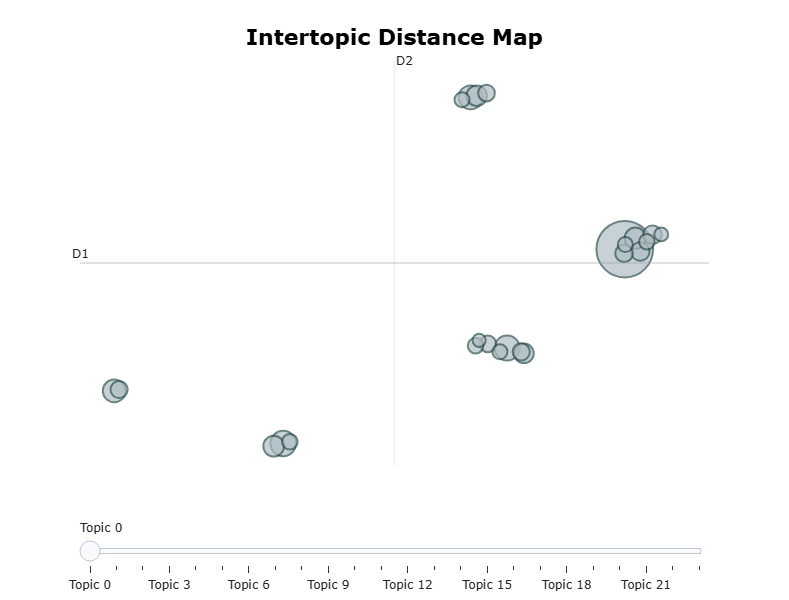

In [61]:
fig = bertopic_model.topic_model.visualize_topics(width = 600, height = 600)
fig

In [25]:
# добавляем  в дтатфрейм( изменяем атрибут .df)
#столбцы topic - номер  кластера, probs - вероятность принадлежности к кластеру (важность?)
# Для зависмых текстов probs = 0 ( заглушка для дальнейшего отбора токенов d LLM, если  вокно не укладываемся)

if 'topic' in df_1.df.columns:
    df_1.df = df_1.df.drop(columns=['topic', 'probs'], errors='ignore')
df_1.df = df_1.df.join(pd.DataFrame({'topic': topics,'probs':np.round(probs,3)}, index=index_df))
df_1.df['probs'] = df_1.df['probs'].fillna(0)
df_1.df.sample(5)   
    

,date,chat_name,chat_id,sender_id,sender_type,message_id,type,reply_to_message_id,user_name,first_name,last_name,text,topic,probs
646,2025-02-20 23:36:00,💬 Data Practicum Chat,1379846874,172748379,user,267449,message,267446,Anna Glagoleva,Anna,Glagoleva,"Щас все HR расстроились, что их за людей не сч...",8.0,0.525
330,2025-02-06 22:06:50,💬 Data Practicum Chat,1379846874,317277992,user,267035,message,267033,Ksenia,Ksenia,,Правильно ❤️,15.0,1.000
39,2025-02-03 12:20:52,💬 Data Practicum Chat,1379846874,1349934990,user,266738,message,266733,Илья,Илья,,Это всё для меня? 🙈,8.0,1.000
911,2025-02-25 19:10:02,💬 Data Practicum Chat,1379846874,947139537,user,267735,message,267732,Ilya Plotnikov,Ilya,Plotnikov,а ты уже 6к вместо 5 из-за инфляции берешь?,0.0,1.000
292,2025-02-05 23:09:39,💬 Data Practicum Chat,1379846874,1798021720,user,266997,message,266968,Юра Лазарев,Юра,Лазарев,🫠,NaN,0.000


Алгоритм разметки зависимых сообщений с использованием полученных кластеров сталкивается с трудностью: некоторые сообщения ссылаются не на родительское сообщение, а на сообщение в цепочке ответов, которое, в свою очередь, также ещё не размечено

Наблюдается  что то вроде рекурсии  сначала размечаются ссобщения '1 уровня'  затем цикл повторяется и размечаютя сообщения  'второго уровня'  и так далее  пока критерий   ['topic'].sna()sum() не перестает меняться.
Создаем словарь, где ключами являются номера топиков, а значениями — списки ID-сообщений, входящих в соответствующие кластеры. Если для какого-либо сообщения существует поле reply_message, и его ID присутствует в списке значений по соответствующему ключу, то этому сообщению присваивается значение этого ключа.
Проверяется условие: если количество  пропусков не изменилось значит процесс разметки окончен.

(Код тяжелый,  хотел бы более легкого ршения)

In [26]:
print(df_1.df.topic.isna().sum())


while True:
    term = df_1.df['topic'].isna().sum()
    dict_1 = { i: df_1.df[df_1.df['topic'] == i]['message_id'].to_list() for i in  df_1.df.topic.dropna().unique()}
    for i in dict_1:
        df_1.df.loc[df_1.df['reply_to_message_id'].isin(dict_1[i]),'topic'] = i
    
    # Если количество NaN значений не изменилось, выходим из цикла
    if  term == df_1.df['topic'].isna().sum():
        break


# короткие  строки
print(df_1.df.topic.isna().sum())

162
104


In [27]:
df_1.df.sample(5)

,date,chat_name,chat_id,sender_id,sender_type,message_id,type,reply_to_message_id,user_name,first_name,last_name,text,topic,probs
620,2025-02-20 22:18:00,💬 Data Practicum Chat,1379846874,168336377,user,267422,message,267416,Мариян Умагалова,Мариян,Умагалова,Найдем мы тебе кальянщицу),0.0,1.0
823,2025-02-24 13:04:32,💬 Data Practicum Chat,1379846874,589815330,user,267642,message,267641,"Катерина Ефремова [+2,5ч мск]",Катерина,Ефремова,Общечеловеческие правила в сообществе никто не...,0.0,1.0
698,2025-02-21 14:47:58,💬 Data Practicum Chat,1379846874,62472764,user,267501,message,267500,Oleg Zhukov,Oleg,Zhukov,"Мне кажется, это не так работает)\nЕго надо бы...",0.0,1.0
658,2025-02-20 23:42:51,💬 Data Practicum Chat,1379846874,172748379,user,267461,message,-1,Anna Glagoleva,Anna,Glagoleva,Я мало кому нравлюсь,2.0,1.0
430,2025-02-10 13:19:11,💬 Data Practicum Chat,1379846874,589815330,user,267182,message,267180,"Катерина Ефремова [+2,5ч мск]",Катерина,Ефремова,Я тоже😁,0.0,1.0


### 4. LLM выделение темы из корпуса текстов

In [28]:
system_message = '''Выдели основную тему из. текста.
Начни с краткого и ёмкого названия темы (от 5 до 10 слов), точно отражающего суть текста.
Затем выдели ключевые слова и фразы (5–10).
В конце сформулируй главную мысль.
Не добавляй лишнего текста.
Формат ответа 'Здесь укажиосновную тему'||'Здесь укажи ключевые слова'||'Здесь сформулируй главную мысль'
'''
user_message = user_message = '{text}'

Выделение темы реализовано  с использованием  класса TopicLLMLL:

Выбрана модель ChatYandexGPT ( поддерживаются сообщения формата LangChain )
def __init__(self, task: str, format_user_messages: str):
task - ситемное  сообщение, format_user_messages - сообщение пользователя.
Реализован  магический метод __call__  парметр датафрейм  с обязательными полями 'topic',  'text'
В дальнейшем планируется вынести в TopicLLMll  в отдельный модуль

In [29]:
class TopicLLMll():
    def __init__(self, task: str, format_user_messages: str, max_tokens: int = 8000):
        self.max_tokens = max_tokens
        self.task = task
        self.format = format_user_messages
    system_message ='{task}'
    user_message = '{text}\n {format_user_messages}'
    user_message = user_message = "{text} "
    
    prompt_template = ChatPromptTemplate.from_messages([
        ('system', system_message),('user',user_message)])
   
    
    enc = tiktoken.get_encoding("cl100k_base")
    
    if os.getenv('FOLDER_ID') and os.getenv('YC_API_KEY'):
        # chat_model = ChatYandexGPT(folder_id = os.getenv('FOLDER_ID'))
        chat_model = ChatYandexGPT(
            folder_id=os.getenv("FOLDER_ID"),
            model_uri=f"gpt://{os.getenv('FOLDER_ID')}/yandexgpt-32k/latest"
         )
        
    else: 
        raise  ValueError("Both environment variables must be set: FOLDER_ID and YC_API_KEY")

    def __call__(self, df_top: pd.DataFrame):
        df_top =df_top.dropna()
        df_top = df_top.sort_values(by='probs', ascending=False)
        topic=[]
        for i in df_top['topic'].unique():
            
            text = ' '.join(df_top[df_top['topic']== i ]['text'].to_list())
            text = self.count_cut_text(text, self.max_tokens)
            
            prompt = self.prompt_template.invoke({'task': self.task, 'text':text})
            topic.append((self.chat_model.invoke(prompt).content, i))
        return topic
                         
    
    def count_cut_text(self, text, max_tokens ):
        tokens = self.enc.encode(text)[:max_tokens]
        return self.enc.decode(tokens)
    

In [30]:
llm_model =TopicLLMll(system_message, user_message)

In [31]:
topic_list = llm_model(df_1.df)

topic_list = [ (*i[0].split('||'), i[1])  for i in topic_list]

df_topic_list = pd.DataFrame(topic_list, columns=['Main Topic',' Keywords','Main Idea','topic']) \
    .set_index('topic') \
    .join(df_1.df['topic'].value_counts().rename('Topic_Frequency')) \
    .reset_index()
df_topic_list = df_topic_list.sort_values(by = 'Topic_Frequency', ascending=False)

df_final = df_1.df.merge(df_topic_list, how='left', on='topic')
df_final = df_final.dropna()

try:
    df_final[['topic','Topic_Frequency']] = df_final[['topic','Topic_Frequency']].astype('int')
    df_topic_list['topic'] = df_topic_list['topic'].astype('int')
except:
    pass

In [32]:
# with pd.option_context ('display.max_colwidth', None):
    # display( df_topic_list.style.set_properties(**{'text-align': 'left', 'white-space' : 'pre-wrap'}))

In [33]:
df_final.head()

,date,chat_name,chat_id,sender_id,sender_type,message_id,type,reply_to_message_id,user_name,first_name,last_name,text,topic,probs,Main Topic,Keywords,Main Idea,Topic_Frequency
2,2025-02-03 11:28:38,💬 Data Practicum Chat,1379846874,312724902,user,266693,message,-1,Olga Varavina,Olga,Varavina,Всем большой привет! Приглашаю на свой уютный ...,11,1.0,'Трудоустройство и аналитика',"'Собеседования, аналитика данных, тестовые зад...",'Автор предлагает подписаться на свой канал с ...,26
3,2025-02-03 11:52:20,💬 Data Practicum Chat,1379846874,1349934990,user,266694,message,266689,Илья,Илья,,А у тебя когда будет свой канал про аналитику?,0,1.0,'Бета-тестирование курсов для аналитиков',"'бета-тестирование, продуктовый аналитик, BI-а...",'Команда курсов «Аналитики данных» приглашает ...,309
4,2025-02-03 11:52:37,💬 Data Practicum Chat,1379846874,1349934990,user,266695,message,-1,Илья,Илья,,Будешь туда голосовухи пятиминутные постить,-1,0.0,Общение в неформальном чате.\n,"'Ключевые слова и фразы': 'чат', 'нюдсы', 'бот...",'Главная мысль': участники чата обмениваются с...,63
5,2025-02-03 11:55:09,💬 Data Practicum Chat,1379846874,60031833,user,266696,message,266654,Sergey,Sergey,,"Потому что сделаны так, будто устарели уже лет...",1,1.0,'Процесс трудоустройства',"'собеседование, эйчар, поиск работы, отбор, HR...","'В тексте обсуждаются сложности, с которыми ст...",111
6,2025-02-03 11:56:57,💬 Data Practicum Chat,1379846874,60031833,user,266697,message,266695,Sergey,Sergey,,Подкаст?),-1,1.0,Общение в неформальном чате.\n,"'Ключевые слова и фразы': 'чат', 'нюдсы', 'бот...",'Главная мысль': участники чата обмениваются с...,63


In [34]:
df_topic_list.head()

,topic,Main Topic,Keywords,Main Idea,Topic_Frequency
3,0,'Бета-тестирование курсов для аналитиков',"'бета-тестирование, продуктовый аналитик, BI-а...",'Команда курсов «Аналитики данных» приглашает ...,309
1,1,'Процесс трудоустройства',"'собеседование, эйчар, поиск работы, отбор, HR...","'В тексте обсуждаются сложности, с которыми ст...",111
4,2,'Общение в рабочем чате',"'Чат практикума, общение, фото, курсы, собесед...",'В тексте описывается общение в рабочем или уч...,103
8,3,'Поиск работы в Альфа-банке',"'вакансия продакта, собеседование, этапы собес...","'В чате обсуждаются вакансии в Альфа-Банке, пр...",82
9,-1,Общение в неформальном чате.\n,"'Ключевые слова и фразы': 'чат', 'нюдсы', 'бот...",'Главная мысль': участники чата обмениваются с...,63


### Запись в excel

In [ ]:
path_dir = Path.cwd()
path_dir.mkdir(parents=True, exist_ok=True)

In [74]:
FOLDER_OUTPUT = 'output_Main_topic_task'
os.makedirs(FOLDER_OUTPUT, exist_ok=True)
path_output = Path.cwd()/FOLDER_OUTPUT
path_output

WindowsPath('C:/Users/dmitr/project_loc/masterskay/Masterskaya/output_Main_topic_task')

In [192]:
def save_excel( df: pd.DataFrame, name_file: str, suffix: str) -> None:
   name = Path(name_file).with_suffix(suffix)
   path_file = path_output/name
   df.to_excel(path_file, index=False, engine='openpyxl')

  

In [76]:

def save_cluster_visual(model: InitBertopic,name_file: str) -> None:
    fig = bertopic_model.topic_model.visualize_topics(width = 1200, height = 800)
    name = Path(name_file).with_suffix('.html')
    path_file = path_output/name
    fig.write_html(path_file)

In [70]:
TOPIC='topic' 
CHAT_TOTAL ='chat_total'
SUFFIX = '.xlsx'

In [208]:
save_excel(df_final, CHAT_TOTAL,SUFFIX)
save_excel(df_topic_list, TOPIC,SUFFIX)


In [77]:
save_cluster_visual(bertopic_model,TOPIC)

Кластер -1.0 BERTopic оценивает как мусорный — без выраженной тематической структуры. 

Предметом  исследовния и настройки могут являться:
- первичная обработка текста(  оценка  важности сообщений,  отбор сообщений для кластеризации,  создание синтетических сообщений
                             для центровки кластеров);
- выбор модели для получения эмбеддингов;
- Настройка редьюкции размерности;
- Кластеризация: выбор алгоритма (HDBSCAN, KMeans и др.) и его параметров;
- выбор LLM : сравнение локальных (бюджетных) и облачных (API) решений с точки зрения качества, скорости и затрат;
- Prompt Engineering 


Отзывы, замечания предложения ревьера:












